In [1]:
import sys
sys.path.append('..')
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import networks
import torch
import mmcv
from mmcv.runner import load_checkpoint
from PIL import Image
from transforms import eval_transform
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import glob


root = '/home/jie.wang/data/CUB_200_2011/images/'
imagelist = sorted(glob.glob(root+'*/*.jpg'))

In [2]:
def read_image(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((448,448))
    print(path)
    plt.figure()
    plt.axis('off')
    plt.imshow(np.array(img))
    input = eval_transform(img)
    return input[None], img

def denormalize(tensor):
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    dtype = tensor.dtype
    mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=dtype, device=tensor.device)
    tensor.mul_(std[:, None, None]).add_(mean[:, None, None])
    return tensor

In [3]:
net = networks.resnet50_wsdan(num_classes=200, num_attentions=32).cuda()
checkpoint = load_checkpoint(net, '../out/resnet50_wsdan/latest.pth')
_ = net.eval()

/home/jie.wang/data/CUB_200_2011/images/016.Painted_Bunting/Painted_Bunting_0094_16467.jpg
tensor(15, device='cuda:0')


/home/jie.wang/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/jie.wang/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


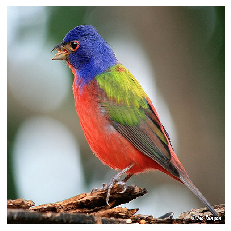

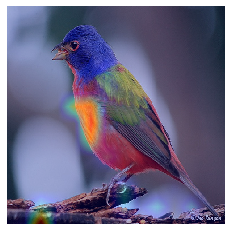

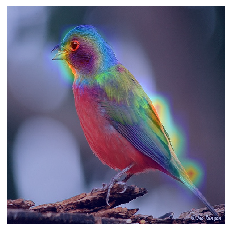

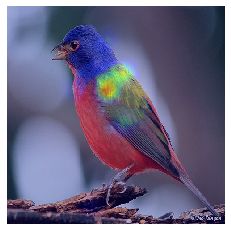

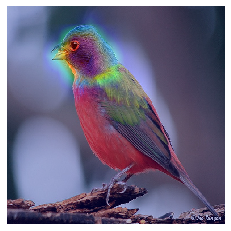

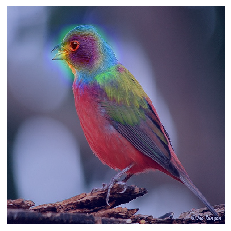

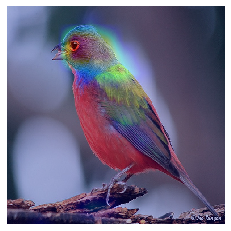

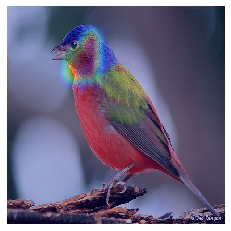

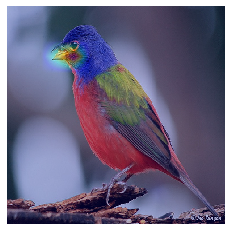

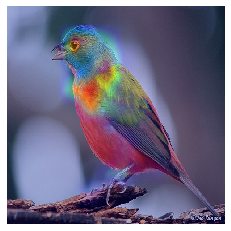

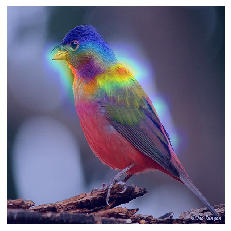

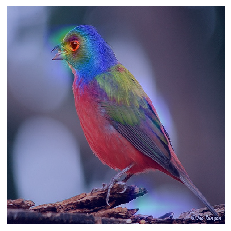

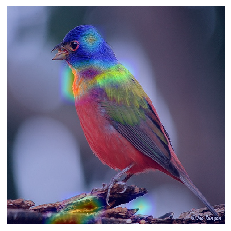

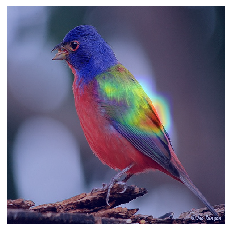

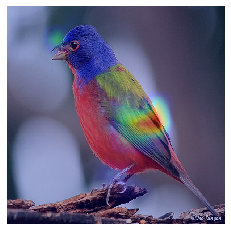

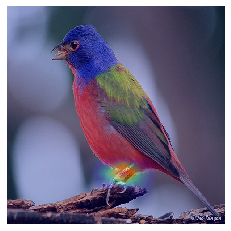

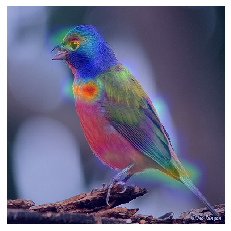

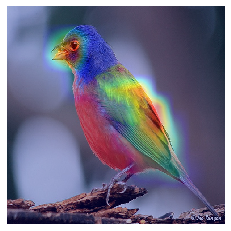

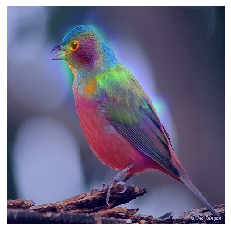

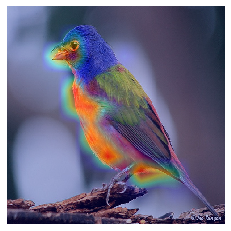

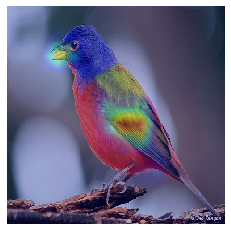

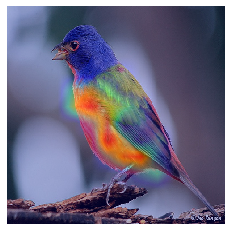

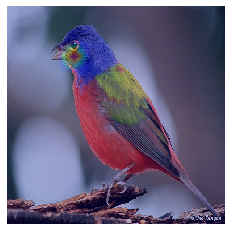

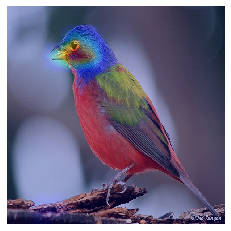

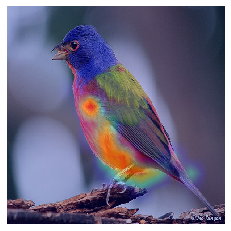

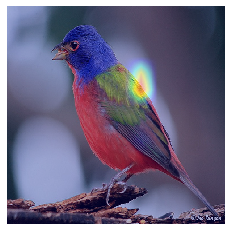

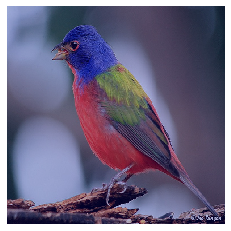

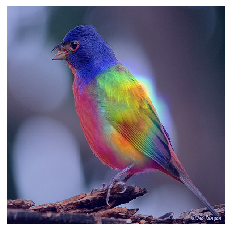

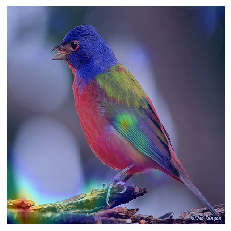

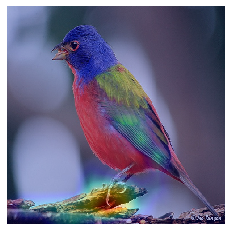

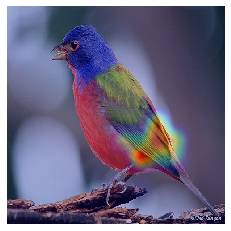

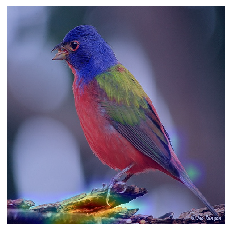

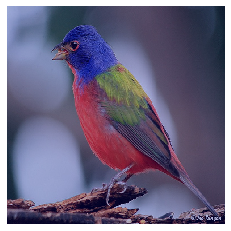

In [22]:
input, img = read_image(imagelist[889])
input = input.cuda()
output, f, att = net(input)
print(torch.argmax(output))

img = np.array(img)

att_map = F.interpolate(att, size=(448,448), mode='bilinear', align_corners=True)
att_map = att_map.squeeze()
for att in att_map:
    att = att.detach().cpu().numpy()
    att = np.uint8((att - att.min()) / (att.max() - att.min()) * 255)
    att = cv.applyColorMap(att, cv.COLORMAP_JET)
    att = cv.cvtColor(att, cv.COLOR_BGR2RGB)
    
    att_img = att * 0.3 + img * 0.7
    att_img = np.uint8(att_img)
    
    plt.figure()
    plt.axis('off')
    plt.imshow(att_img)

In [6]:
att.shape

torch.Size([1, 32, 14, 14])